In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24_with_covariates_buttPress.txt',header = TRUE)
head(df)

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,0.0915,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,PCC1,0.5290,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,PCC2,0.3904,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,rPAG1,0.6907,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,lPAG1,-0.0709,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,rvAI,0.1475,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


# **1. Bayesian Multi-level modeling**

## **Model 1: Varying intercept and varying slope model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + (\beta_{BPD}+\beta_{ROI_{BPD}})*BPD \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$
$$\beta_{BPD} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{BPD}} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [8]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:6] <- "student_t(3,0,10)"
priorRBA$prior[9:10] <- "gamma(3.325,0.1)"
priorRBA$prior[12] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,BPdiff_stdz,,,,,
3,"student_t(3,0,10)",b,STATEdiff,,,,,
4,"student_t(3,0,10)",b,STATEmean,,,,,
5,"student_t(3,0,10)",b,TRAITdiff,,,,,
6,"student_t(3,0,10)",b,TRAITmean,,,,,
7,lkj(1),cor,,,,,,
8,,cor,,ROI,,,,
9,"gamma(3.325,0.1)",df,,ROI,,,,


In [10]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOI = 'Intercept,STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
EOIq


dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Intercept"   "STATEmean"   "TRAITmean"   "STATEdiff"   "TRAITdiff"  
[6] "BPdiff_stdz"

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,0.0915,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,PCC1,0.5290,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,PCC2,0.3904,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,rPAG1,0.6907,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,lPAG1,-0.0709,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,rvAI,0.1475,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


In [11]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'd956566839e0c186dd6f90e1bdca9876' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 759.8 seconds (Warm-up)
Chain 1:                966.77 seconds (Sampling)
C

In [12]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz + (1 | gr(Subj, dist = "student")) + (1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 1464) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~ROI (Number of levels: 24) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                            33.52     18.47     7.76    78.21 1.00     1130
sd(Intercept)                  0.06      0.01     0.03     0.08 1.00     8092
sd(STATEmean)                  0.02      0.01     0.00     0.04 1.00     6610
sd(TRAITmean)                  0.01      0.01     0.00     0.04 1.00     7995
sd(STATEdiff)                  0.03      0.01     0.01     0.06 1.00     7620
sd(TRAITdiff)                  0.0

In [13]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

### Functions

In [14]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **2. BML and GLM Summaries with Posterior Plots**

===== Summary of region effects for Intercept (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0056 0.0344 0.5646 -0.0626 -0.0510  0.0057 0.0613 0.0721
Amygdala_BLBM_La_L  0.0204 0.0367 0.7136 -0.0521 -0.0402  0.0208 0.0803 0.0914
Amygdala_BLBM_La_R  0.0635 0.0379 0.9555 -0.0090  0.0022  0.0629 0.1264 0.1391
Amygdala_CeME_L     0.0577 0.0393 0.9320 -0.0189 -0.0058  0.0574 0.1235 0.1362
Amygdala_CeME_R     0.0360 0.0394 0.8226 -0.0421 -0.0289  0.0363 0.1007 0.1139
lBNST               0.1378 0.0424 0.9997  0.0573  0.0696  0.1368 0.2091 0.2237
lCa                 0.0594 0.0331 0.9650 -0.0053  0.0051  0.0593 0.1134 0.1255
ldAI                0.0961 0.0357 0.9969  0.0268  0.0384  0.0955 0.1553 0.1671
lPa                 0.0909 0.0336 0.9963  0.0259  0.0368  0.0908 0.1467 0.1571
lPAG1               0.0337 0.0363 0.8226 -0.0382 -0.0263  0.0338 0.0924 0.1040
lPI                 0.0096 0.0351 0.6080 -0.0601 -0.0485  0.0096 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00462



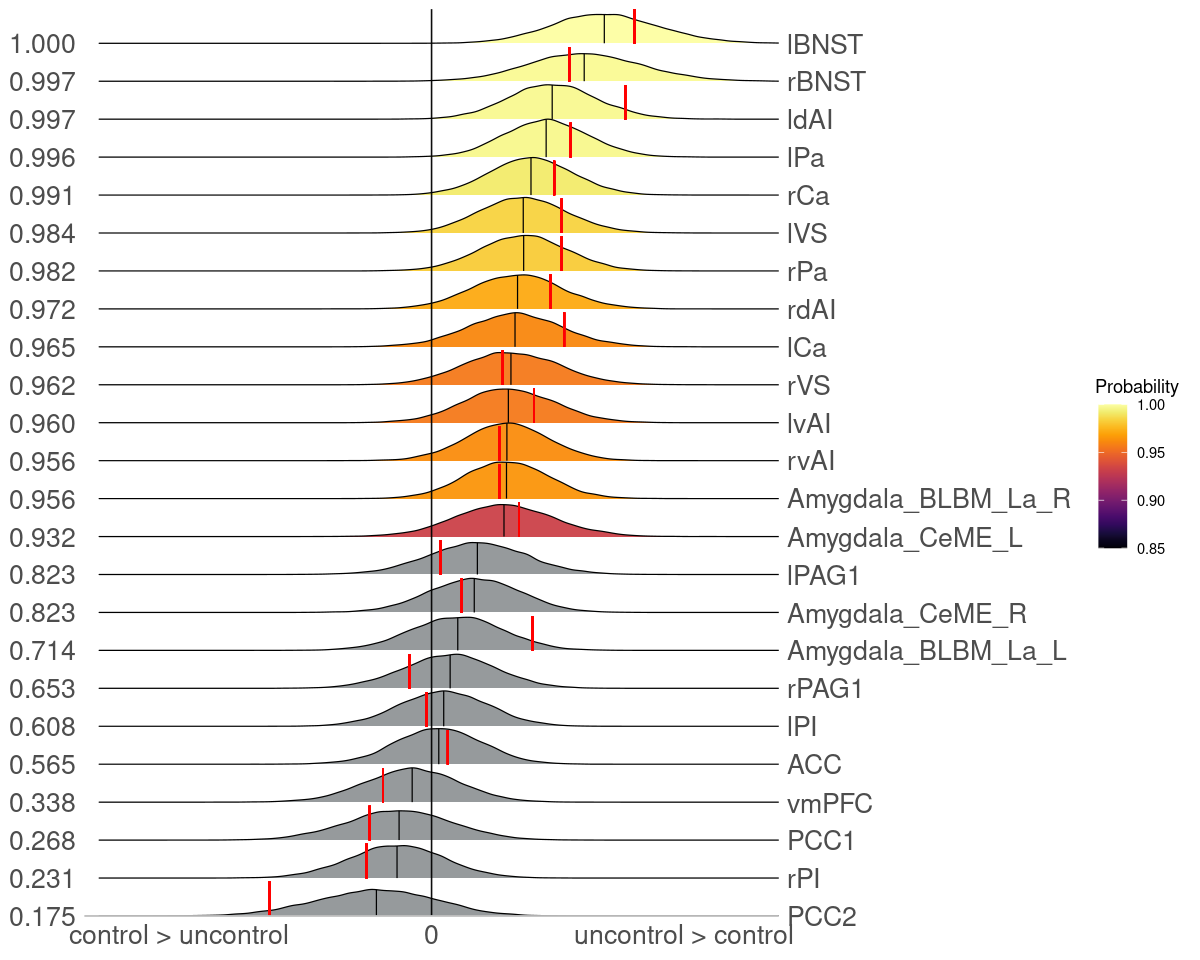

In [15]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

Red vertical lines: GLM

===== Summary of region effects for BPdiff_stdz (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%     95%  97.5%
ACC                 0.0402 0.0342 0.8823 -0.0249 -0.0149  0.0398  0.0974 0.1091
Amygdala_BLBM_La_L  0.0286 0.0349 0.7950 -0.0372 -0.0274  0.0273  0.0881 0.1001
Amygdala_BLBM_La_R  0.0415 0.0373 0.8700 -0.0289 -0.0177  0.0406  0.1041 0.1175
Amygdala_CeME_L     0.0030 0.0347 0.5328 -0.0651 -0.0531  0.0028  0.0612 0.0727
Amygdala_CeME_R     0.0324 0.0368 0.8105 -0.0358 -0.0257  0.0311  0.0955 0.1080
lBNST              -0.0477 0.0428 0.1296 -0.1360 -0.1204 -0.0459  0.0186 0.0306
lCa                 0.0084 0.0309 0.6061 -0.0521 -0.0422  0.0080  0.0592 0.0701
ldAI                0.0005 0.0321 0.5067 -0.0631 -0.0519  0.0005  0.0533 0.0636
lPa                -0.0230 0.0329 0.2466 -0.0891 -0.0779 -0.0224  0.0298 0.0395
lPAG1              -0.0095 0.0332 0.3897 -0.0760 -0.0647 -0.0092  0.0441 0.0551
lPI                 0.0135 0.0322 0.6622 -0.0499 -0.

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00432



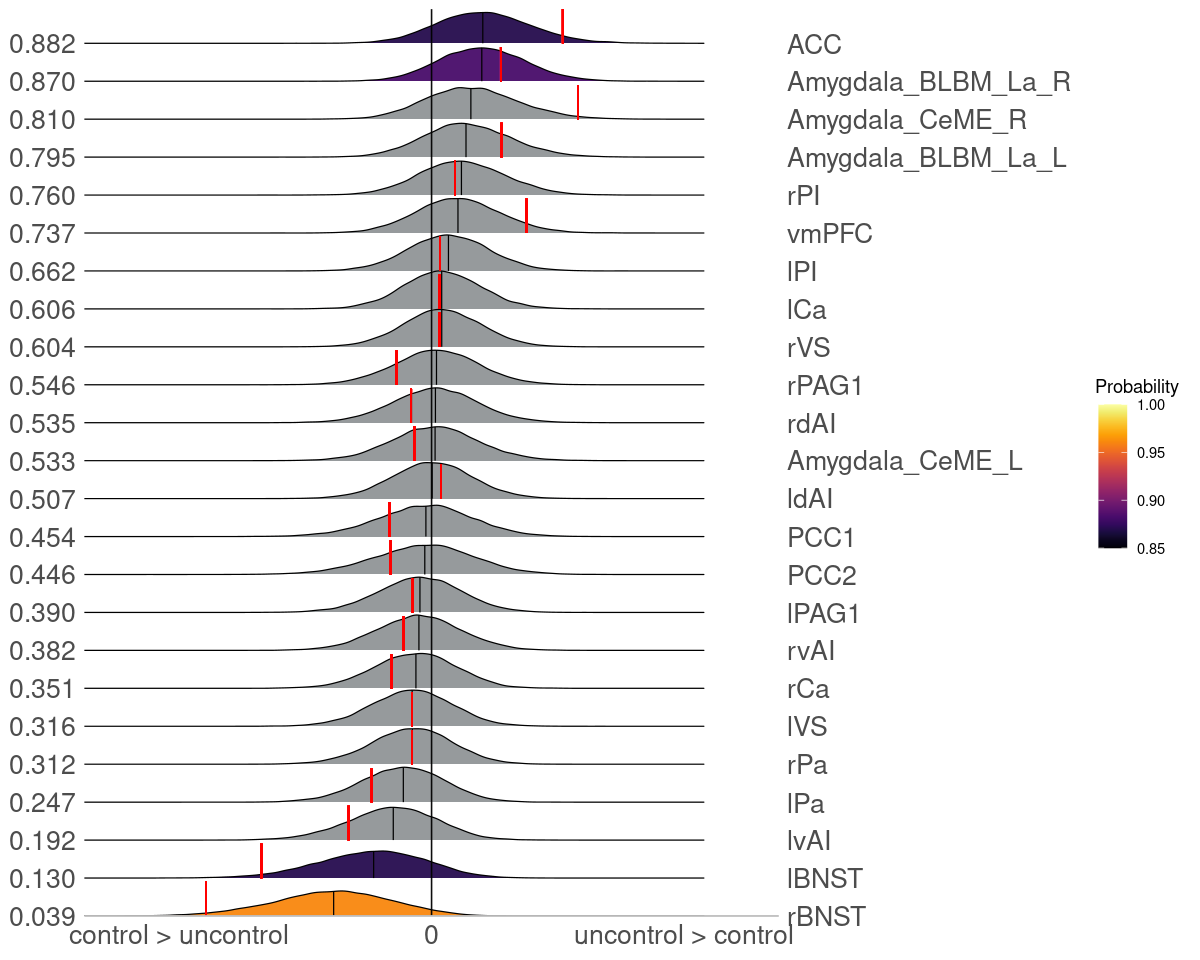

In [16]:
ii = 6
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEmean (RBA results) =====
                     mean     SD     P+    2.5%      5%    50%    95%  97.5%
ACC                0.0053 0.0338 0.5762 -0.0641 -0.0514 0.0063 0.0589 0.0699
Amygdala_BLBM_La_L 0.0094 0.0325 0.6205 -0.0565 -0.0443 0.0097 0.0620 0.0726
Amygdala_BLBM_La_R 0.0069 0.0337 0.5920 -0.0616 -0.0498 0.0076 0.0609 0.0720
Amygdala_CeME_L    0.0169 0.0335 0.6968 -0.0480 -0.0377 0.0167 0.0723 0.0844
Amygdala_CeME_R    0.0081 0.0336 0.6038 -0.0598 -0.0474 0.0086 0.0618 0.0726
lBNST              0.0260 0.0358 0.7682 -0.0412 -0.0302 0.0246 0.0868 0.1003
lCa                0.0137 0.0318 0.6694 -0.0491 -0.0387 0.0139 0.0656 0.0771
ldAI               0.0128 0.0323 0.6566 -0.0514 -0.0404 0.0129 0.0654 0.0764
lPa                0.0179 0.0322 0.7110 -0.0445 -0.0343 0.0175 0.0711 0.0840
lPAG1              0.0168 0.0322 0.7025 -0.0458 -0.0359 0.0165 0.0697 0.0812
lPI                0.0092 0.0325 0.6201 -0.0559 -0.0448 0.0098 0.0620 0.0723
lvAI      

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00406



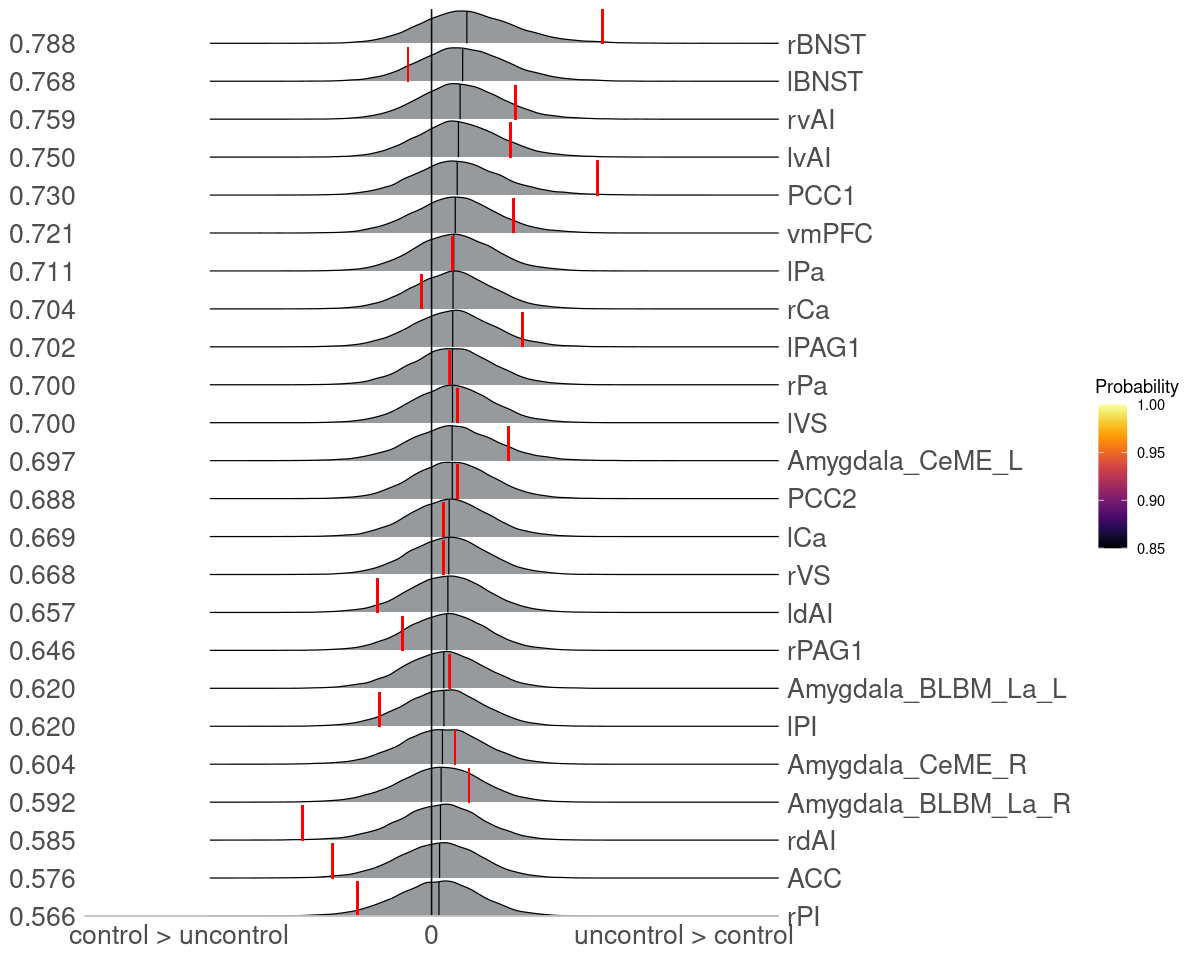

In [17]:
ii = 2
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITmean (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0096 0.0323 0.3680 -0.0711 -0.0610 -0.0105 0.0444 0.0568
Amygdala_BLBM_La_L -0.0179 0.0311 0.2774 -0.0794 -0.0687 -0.0181 0.0335 0.0434
Amygdala_BLBM_La_R -0.0107 0.0327 0.3560 -0.0730 -0.0624 -0.0114 0.0445 0.0566
Amygdala_CeME_L    -0.0190 0.0318 0.2671 -0.0829 -0.0714 -0.0187 0.0326 0.0435
Amygdala_CeME_R    -0.0116 0.0319 0.3482 -0.0729 -0.0623 -0.0122 0.0416 0.0530
lBNST              -0.0171 0.0328 0.2952 -0.0812 -0.0702 -0.0172 0.0365 0.0475
lCa                -0.0150 0.0307 0.3072 -0.0757 -0.0649 -0.0151 0.0358 0.0458
ldAI               -0.0173 0.0310 0.2844 -0.0790 -0.0678 -0.0174 0.0337 0.0434
lPa                -0.0203 0.0310 0.2517 -0.0822 -0.0715 -0.0202 0.0298 0.0402
lPAG1              -0.0189 0.0309 0.2670 -0.0810 -0.0699 -0.0188 0.0317 0.0416
lPI                -0.0144 0.0311 0.3144 -0.0747 -0.0644 -0.0148 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00386



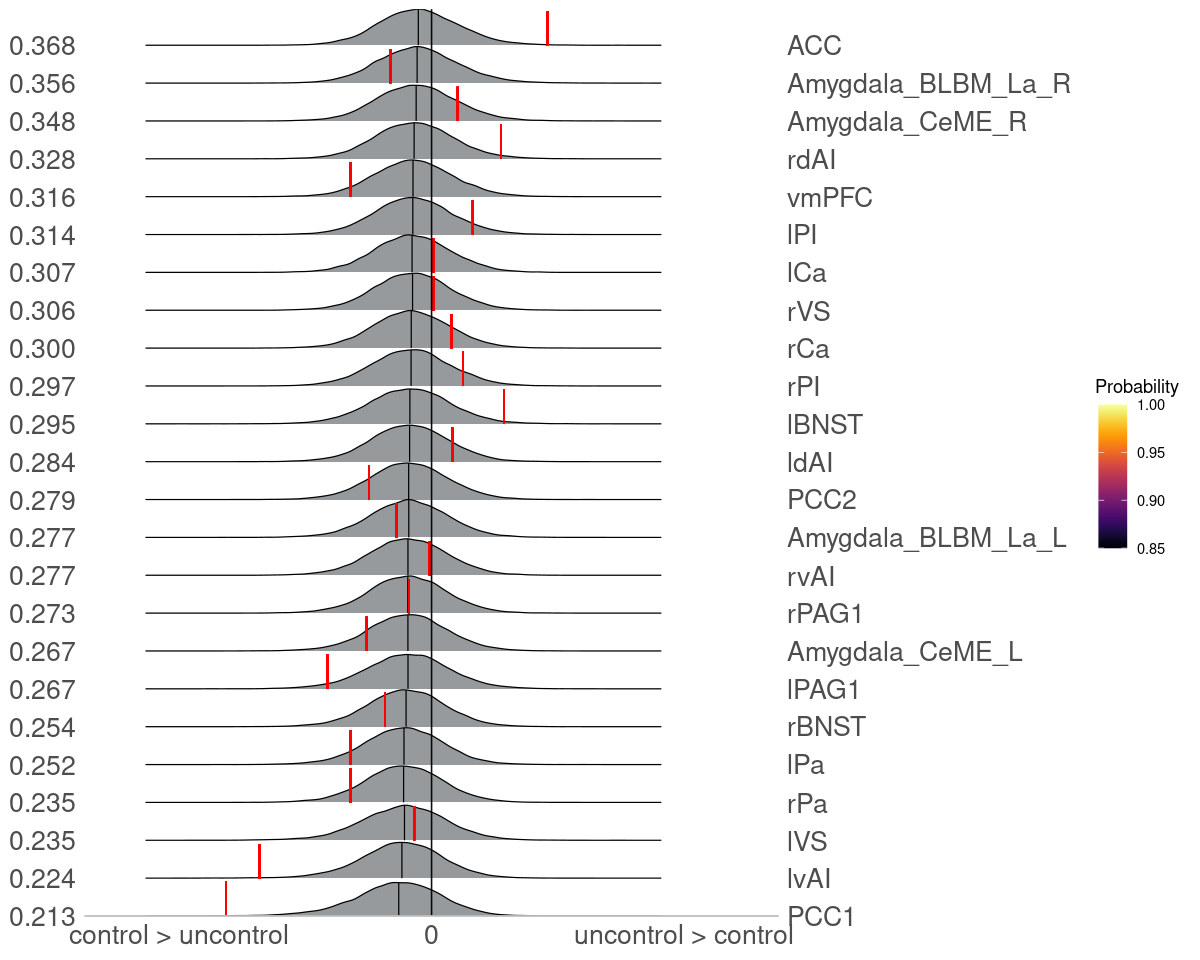

In [18]:
ii = 3
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0043 0.0304 0.4502 -0.0646 -0.0547 -0.0036 0.0450 0.0547
Amygdala_BLBM_La_L  0.0053 0.0315 0.5643 -0.0571 -0.0461  0.0050 0.0576 0.0680
Amygdala_BLBM_La_R  0.0381 0.0361 0.8588 -0.0274 -0.0179  0.0361 0.1009 0.1144
Amygdala_CeME_L     0.0094 0.0325 0.6185 -0.0559 -0.0442  0.0093 0.0632 0.0736
Amygdala_CeME_R     0.0215 0.0322 0.7494 -0.0399 -0.0300  0.0208 0.0762 0.0864
lBNST               0.0479 0.0362 0.9132 -0.0197 -0.0098  0.0468 0.1093 0.1220
lCa                 0.0256 0.0302 0.8042 -0.0317 -0.0230  0.0247 0.0766 0.0868
ldAI                0.0274 0.0306 0.8172 -0.0320 -0.0224  0.0270 0.0788 0.0884
lPa                 0.0274 0.0301 0.8226 -0.0309 -0.0216  0.0268 0.0772 0.0881
lPAG1               0.0085 0.0306 0.6101 -0.0518 -0.0415  0.0086 0.0591 0.0696
lPI                -0.0019 0.0304 0.4790 -0.0627 -0.0523 -0.0015 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00402



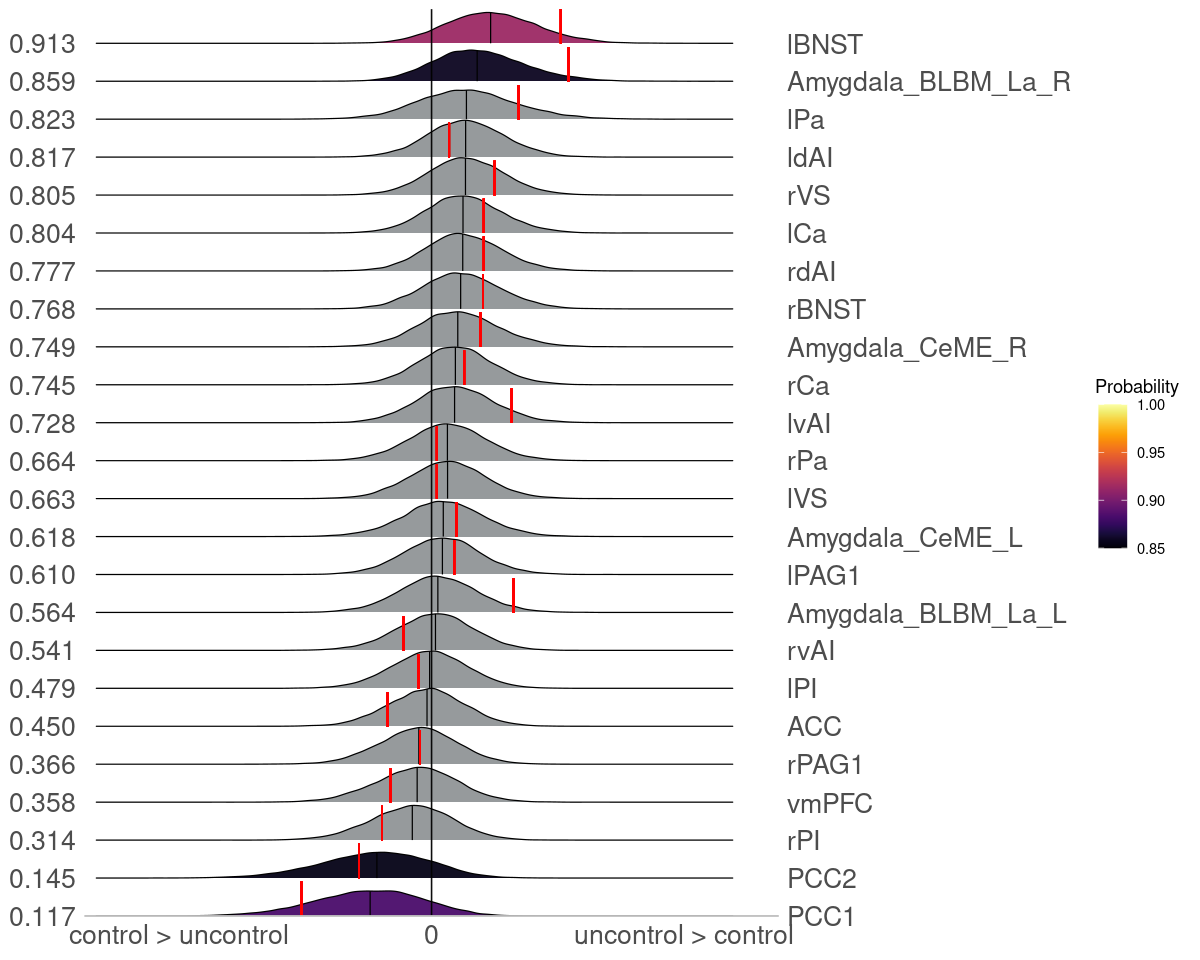

In [19]:
ii = 4
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0034 0.0250 0.5528 -0.0459 -0.0376  0.0033 0.0444 0.0532
Amygdala_BLBM_La_L  0.0063 0.0250 0.6014 -0.0422 -0.0343  0.0059 0.0481 0.0565
Amygdala_BLBM_La_R  0.0035 0.0253 0.5588 -0.0461 -0.0381  0.0036 0.0451 0.0535
Amygdala_CeME_L     0.0025 0.0252 0.5432 -0.0473 -0.0389  0.0026 0.0439 0.0523
Amygdala_CeME_R     0.0046 0.0252 0.5751 -0.0447 -0.0364  0.0044 0.0465 0.0550
lBNST               0.0064 0.0265 0.5923 -0.0451 -0.0362  0.0058 0.0505 0.0603
lCa                 0.0052 0.0245 0.5849 -0.0424 -0.0348  0.0050 0.0461 0.0543
ldAI                0.0041 0.0251 0.5688 -0.0452 -0.0369  0.0039 0.0457 0.0545
lPa                 0.0018 0.0251 0.5313 -0.0483 -0.0395  0.0019 0.0429 0.0509
lPAG1               0.0065 0.0251 0.5996 -0.0419 -0.0339  0.0060 0.0484 0.0572
lPI                 0.0071 0.0250 0.6103 -0.0416 -0.0334  0.0066 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00308



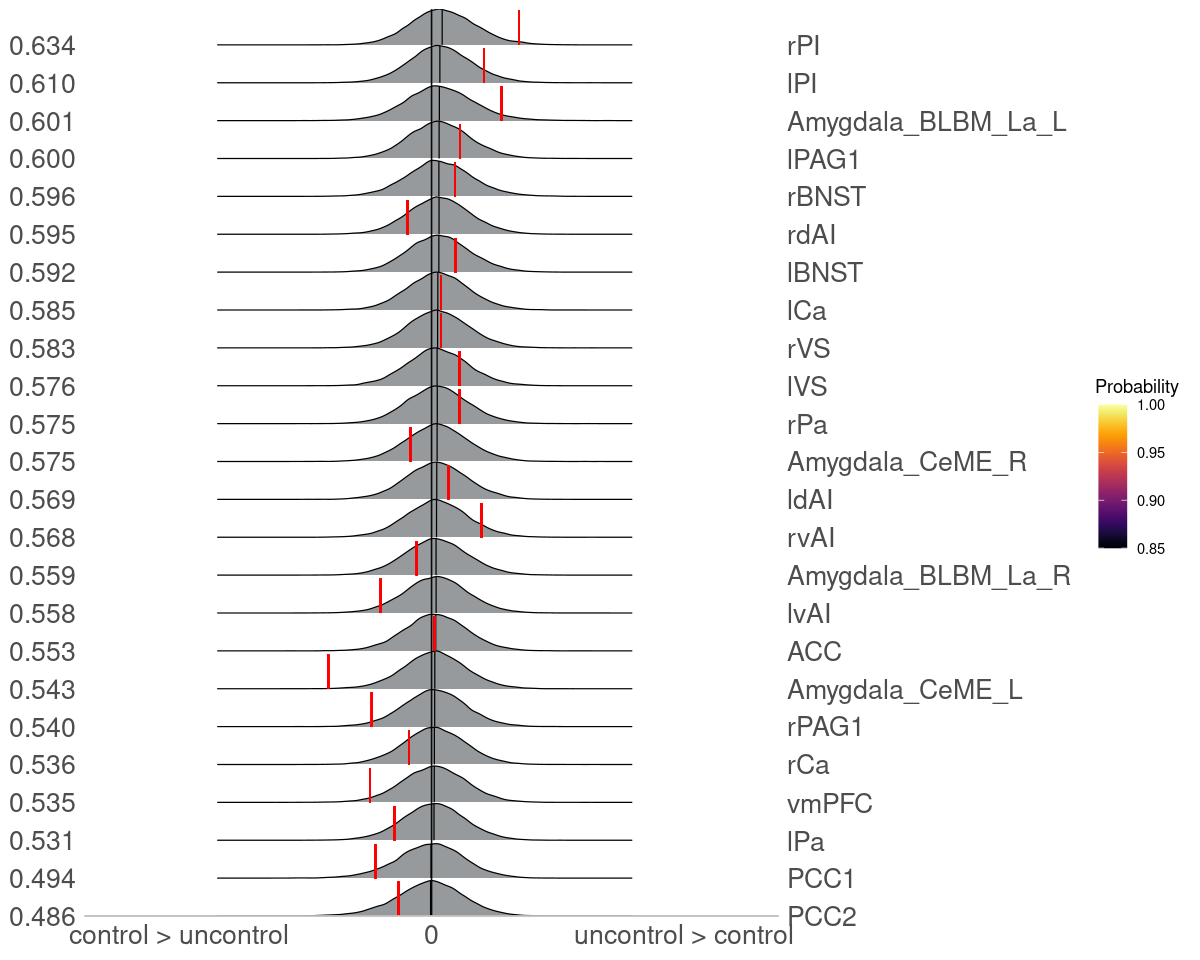

In [20]:
ii = 5
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

# **3. Posterior Predictive Check**

In [21]:
pp_plot = pp_check(fm,nsamples = 100)

Warning message:
“Removed 974 rows containing non-finite values (stat_density).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density).”


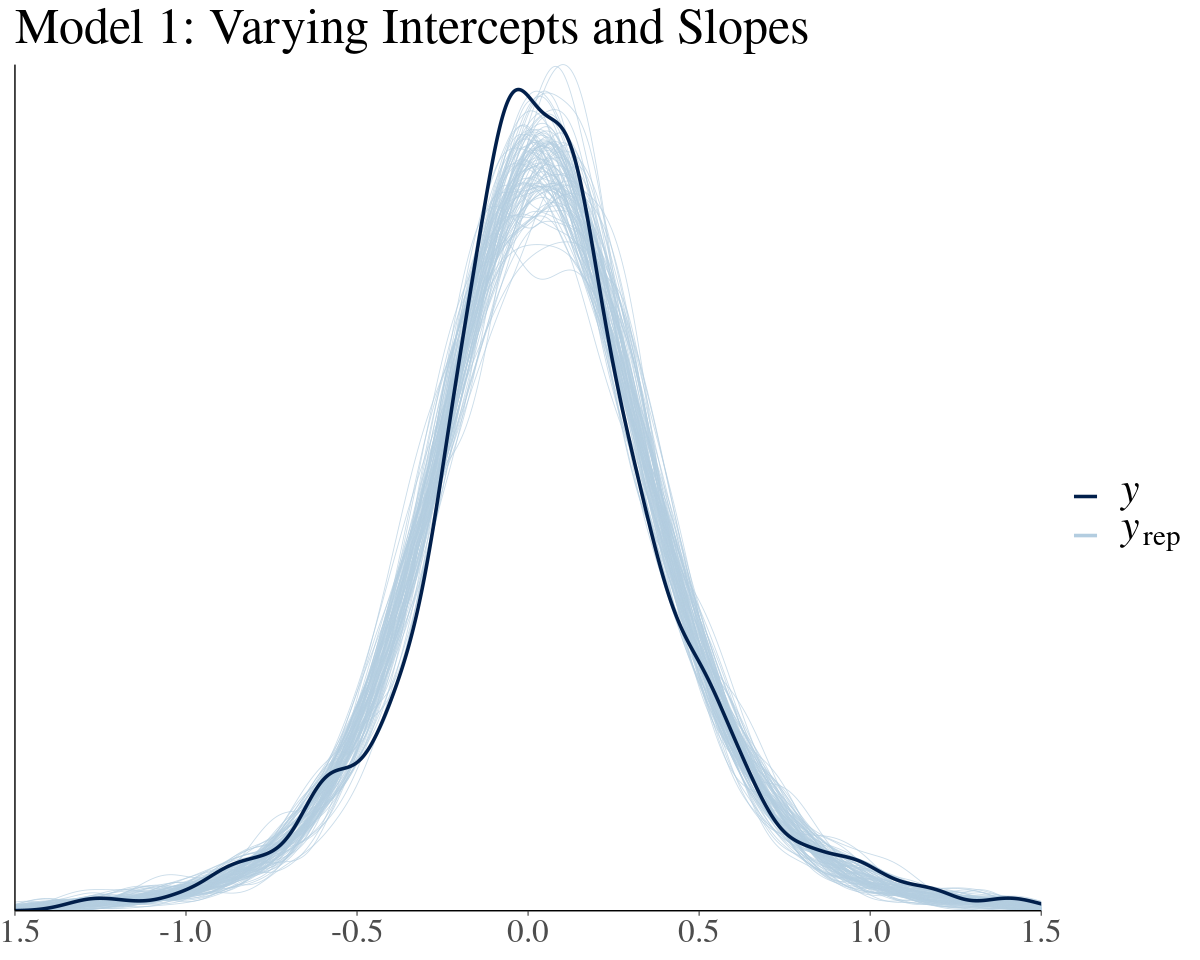

In [22]:
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)